# Imports

put comments here related to library management

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tempfile
import zipfile


from tensorflow.keras import layers, models
from IPython import display

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras import Sequential

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras
from keras.layers import Resizing
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer

import nbimporter

# Run .py preprocessing that sets up the datasets

In [2]:
# Function to parse a single serialized example from TFRecord
def _parse_function(proto):
    # Define the feature description (same as the structure you used when saving)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image is stored as a string
        'label': tf.io.FixedLenFeature([], tf.int64),   # Label is an int64
    }
    
    # Parse the input `tf.train.Example` proto using the feature description
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    
    # Decode the JPEG-encoded image back into a float32 tensor
    image = tf.io.decode_jpeg(parsed_example['image'], channels=1)  # Grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to [0, 1] range
    
    # Reshape the image to its original shape (e.g., [124, 129, 1])
    image = tf.reshape(image, [124, 129, 1])
    
    # Get the label
    label = parsed_example['label']
    
    return image, label

In [3]:
# Function to load the dataset from a TFRecord file
def load_dataset(tfrecord_file, batch_size=64):
    # Load the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    
    # Parse the serialized data using the _parse_function
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and shuffle the dataset (optional, depending on your needs) buffer_size is not size of batch its size of buffer
    parsed_dataset = parsed_dataset.shuffle(buffer_size=1000).batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return parsed_dataset

In [4]:
# Load the train, test, and validation datasets from TFRecord files
train_spectrogram_ds = load_dataset('train_spec_ds.tfrecord')
test_spectrogram_ds = load_dataset('test_spec_ds.tfrecord')
val_spectrogram_ds = load_dataset('val_spec_ds.tfrecord')

In [5]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    num_classes = 6
    print('Input shape:', input_shape)
    print('Number of classes:', num_classes)

New dataset size: 213
Input shape: (64, 124, 129, 1)
Number of classes: 6


In [6]:
new_size = len(list(test_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 27


# Define models

In [7]:
import audio_models

# Weight initializations?

## Train Models


Training Model 0


Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



213/213 [==============================] - 3s 11ms/step - loss: 1.1566 - accuracy: 0.5620 - val_loss: 1.0315 - val_accuracy: 0.6035
Epoch 2/20
213/213 [==============================] - 2s 10ms/step - loss: 0.9203 - accuracy: 0.6604 - val_loss: 0.8694 - val_accuracy: 0.6835
Epoch 3/20
213/213 [==============================] - 2s 11ms/step - loss: 0.7136 - accuracy: 0.7444 - val_loss: 0.7066 - val_accuracy: 0.7535
Epoch 4/20
213/213 [==============================] - 2s 11ms/step - loss: 0.5976 - accuracy: 0.7848 - val_loss: 0.6875 - val_accuracy: 0.7500
Epoch 5/20
213/213 [==============================] - 2s 11ms/step - loss: 0.5163 - accuracy: 0.8118 - val_loss: 0.6243 - val_accuracy: 0.7918
Epoch 6/20
213/213 [==============================] - 2s 11ms/step - loss: 0.4516 - accuracy: 0.8396 - val_loss: 0.6095 - val_accuracy: 0.7918
Epoch 7/20
213/213 [==============================] - 2s 11ms/step - loss: 0.4065 - accuracy: 0.8556 - val_loss: 0.5928 - val_accuracy: 0.7976
Epoch 8/2

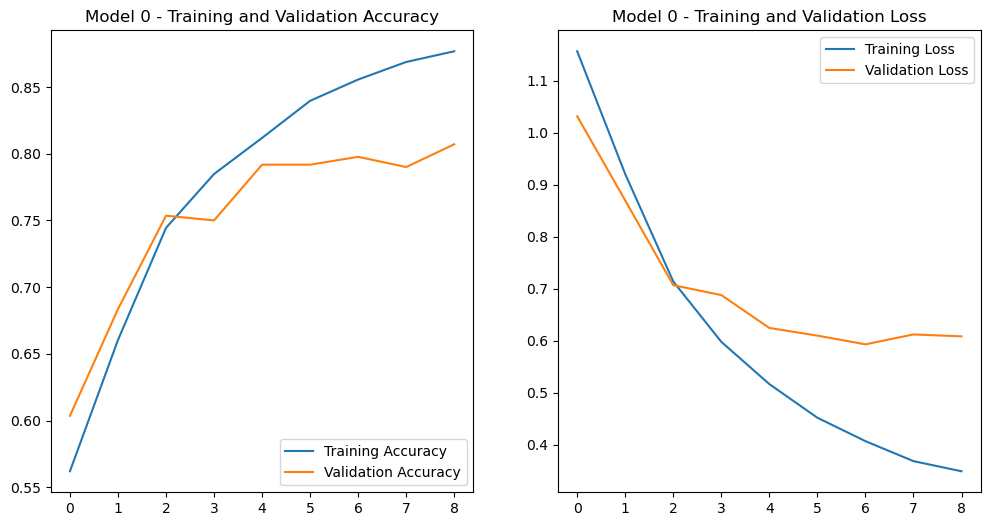


Training Model 1
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)         

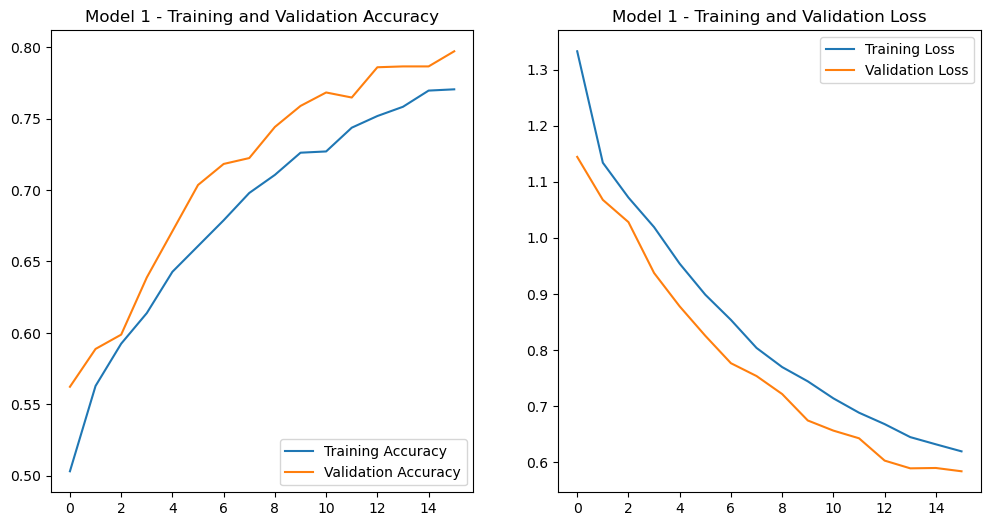


Training Model 2
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         
                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
                                                                 
 flatten (Flatten)    

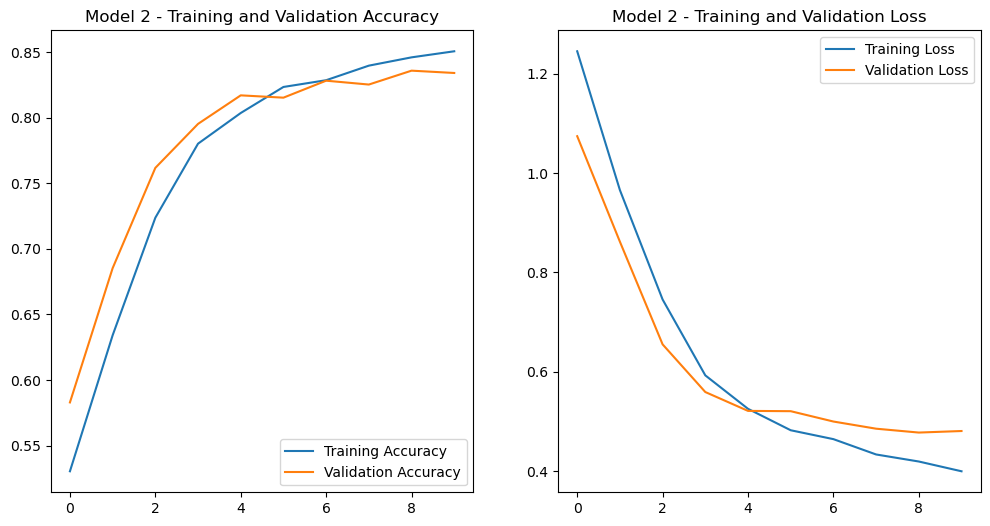

In [8]:
models = []
histories = []
sequential_models = True

for i, create_model in enumerate([audio_models.create_tiny_conv_model_small, audio_models.create_tiny_embed_conv_model_small,
                                audio_models.create_tiny_embed_conv_model_small_best]):
    print(f'\nTraining Model {i}')
    input_shape = (124, 129, 1)
    model = create_model(input_shape)
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()


    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=20,  # You can adjust the number of epochs
        callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.01),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    audio_models.plot_training_history(history, i)


## Compile and test models

In [9]:
len(models)

3

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tempfile
import zipfile
import os

# Function to reload any serialized models (from bytes) if necessary
def load_if_serialized(model):
    if isinstance(model, bytes):
        # Assuming the model was saved as bytes, use `tf.keras.models.model_from_json` or similar
        raise TypeError("Model is in a serialized bytes format. Please load it as a Keras model before passing.")
    return model

def get_gzipped_model_size(model):
    # Save the model to a temporary file in .keras format
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as temp_file:
        model.save(temp_file.name)
        model_filename = temp_file.name

    # Compress the model file to calculate its gzipped size
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_zip:
        zipped_file = temp_zip.name
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_filename, arcname='model.keras')

    # Get the size of the gzipped model file in kilobytes
    gzipped_size = os.path.getsize(zipped_file) / 1000  # Convert bytes to KB

    # Clean up temporary files
    os.remove(model_filename)
    os.remove(zipped_file)

    return gzipped_size

def plot_size_v_accuracy(models, test_spectrogram_ds):
    # Lists to store the results
    accuracies = []
    model_sizes = []
    model_names = []

    # Evaluate each model and store the results
    for i, model in enumerate(models, start=1):
        try:
            # Load model if it's in serialized bytes format
            model = load_if_serialized(model)

            # Check if model is a Keras model instance
            #if not isinstance(model, tf.keras.Model):
            #    raise TypeError(f"Model {i} is not a Keras model instance.")

            # Check if the model is compiled by looking for an optimizer
            if model.optimizer is None:
                model.compile(
                    optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']
                )
            
            # Evaluate the model
            test_loss, test_acc = model.evaluate(test_spectrogram_ds, verbose=0)

            # Calculate the gzipped model size
            gzipped_size = get_gzipped_model_size(model)

            # Print the details
            print(f"Model {i} ({model.name}):")
            print(f"  Gzipped Model Size: {gzipped_size:.2f} KB")
            print(f"  Test Accuracy: {test_acc:.4f}")
            
            # Store the accuracy and model size
            accuracies.append(test_acc)
            model_sizes.append(gzipped_size)
            model_names.append(model.name)

        except Exception as e:
            print(f"An error occurred with Model {i}: {e}")

    # Plotting accuracy vs. gzipped model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Gzipped Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Accuracy vs. Gzipped Model Size')
    plt.grid(True)
    plt.show()

# Example usage
# plot_size_v_accuracy(models, test_spectrogram_ds)



c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model 1 (tiny_conv_model):
  Gzipped Model Size: 2203.62 KB
  Test Accuracy: 0.7994
Model 2 (tiny_embed_conv_model):
  Gzipped Model Size: 108.28 KB
  Test Accuracy: 0.7953
Model 3 (tiny_embed_conv_model_best):
  Gzipped Model Size: 413.40 KB
  Test Accuracy: 0.8329


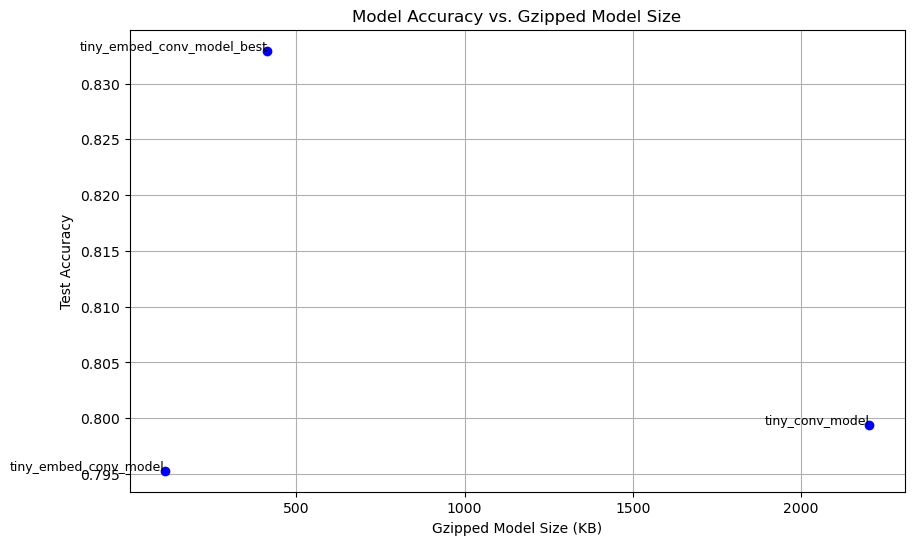

In [11]:
plot_size_v_accuracy(models, test_spectrogram_ds)

# Shrinking the model

[deployment on the edge](https://ai.google.dev/edge/litert)

[general model optimizations](https://www.tensorflow.org/model_optimization/guide)

We will start off with pruning

we will aslo try quantization aware training to quantize the model
and we will also try different post-training quantizations

we can also try weight clustering

and finalyl we will try a single workflow with a combination of the previous methods
[collaborative optimizations](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)


https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html



# Pruning

In [12]:
### Helper functions for pruning

def ds_to_numpy(dataset):

    # Assume your dataset is named `train_dataset`
    data = []
    labels = []

    # Iterate over the dataset and separate data and labels
    for features, label in dataset:
        data.append(features)
        labels.append(label)

    # Convert lists of data and labels into tensors if needed
    data = tf.concat(data, axis=0)
    labels = tf.concat(labels, axis=0)

    return data, labels

def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # Ignore auxiliary weights if any exist
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(f"{weight.name}: {zero_num/weight_size:.2%} sparsity ({zero_num}/{weight_size})")



In [13]:

def prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False):

    train_data, train_labels = ds_to_numpy(train_spectrogram_ds)
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)

    # Define pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
    }
    
    # Define pruning callbacks
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    
    # Apply pruning to the model
    if qat:
        quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              stripped_pruned_model)
        pruned_model = tfmot.quantization.keras.quantize_apply(
                    quant_aware_annotate_model,
                    tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())
    else:
        # If the model is a standard model, apply pruning normally
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Compile the pruned model with a smaller learning rate for fine-tuning
    pruned_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    pruned_model.summary()
    
    # Fine-tune the pruned model
    pruned_model.fit(
        train_data,
        train_labels,
        epochs=3,
        validation_split=0.1,
        callbacks=callbacks
    )
    
    # Strip pruning wrappers for final deployment
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
    
    # Check sparsity levels
    print_model_weights_sparsity(stripped_pruned_model)


    # Evaluate the pruned model on test data
    _, pruned_model_accuracy = pruned_model.evaluate(test_data, test_labels, verbose=0)
    print("Pruned test accuracy:", pruned_model_accuracy)
    
    return stripped_pruned_model


In [14]:
len(models)

3

In [15]:
basic_pruned_models = []

for model in models:
    pruned_model = prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False)
    basic_pruned_models.append(pruned_model)


Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv (  (None, 62, 65, 8)         1290      
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_relu1   (None, 62, 65, 8)         1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 62, 65, 8)         1         
 t1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_flatte  (None, 32240)             1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_fc2 (P  (None, 6)             

c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


383/383 [==============================] - 6s 8ms/step - loss: 0.4818 - accuracy: 0.8221 - val_loss: 0.4589 - val_accuracy: 0.8176
Epoch 2/3
383/383 [==============================] - 3s 7ms/step - loss: 0.4791 - accuracy: 0.8223 - val_loss: 0.4098 - val_accuracy: 0.8471
Epoch 3/3
383/383 [==============================] - 3s 7ms/step - loss: 0.4403 - accuracy: 0.8411 - val_loss: 0.3824 - val_accuracy: 0.8640
conv/kernel:0: 50.00% sparsity (320/640)
conv/bias:0: 0.00% sparsity (0/8)
fc2/kernel:0: 50.00% sparsity (96720/193440)
fc2/bias:0: 0.00% sparsity (0/6)
Pruned test accuracy: 0.7747058868408203
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1   (None, 62, 65, 8)         1290      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_relu1   (No

Model 1 (tiny_conv_model):
  Gzipped Model Size: 439.85 KB
  Test Accuracy: 0.7747
Model 2 (tiny_embed_conv_model):
  Gzipped Model Size: 24.18 KB
  Test Accuracy: 0.7900
Model 3 (tiny_embed_conv_model_best):
  Gzipped Model Size: 84.99 KB
  Test Accuracy: 0.8371


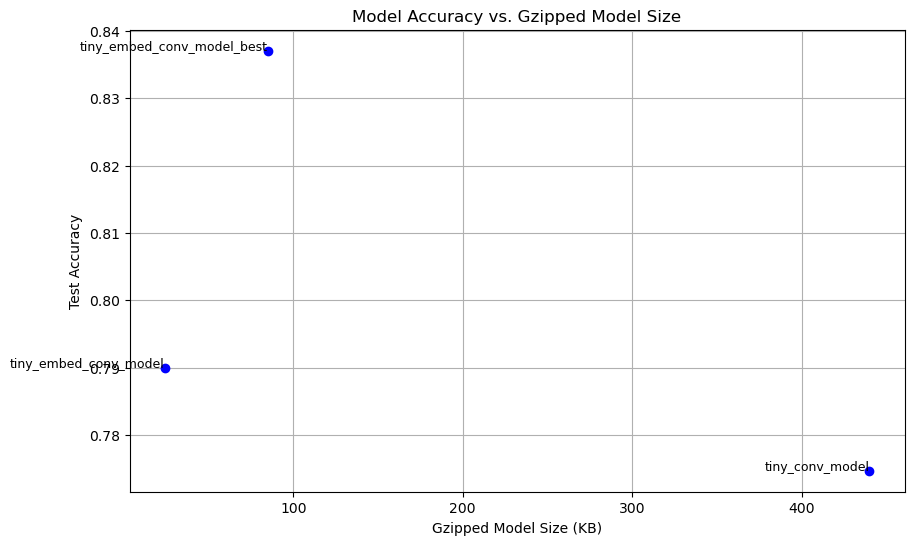

In [16]:
plot_size_v_accuracy(basic_pruned_models, test_spectrogram_ds)


## Pruning preserving quantization aware training (PQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html


we can also add some weight clustering?

## quantization aware training quantized models with or without pruning
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide#quantize_some_layers

In [17]:
#import tensorflow_model_optimization as tfmot

#quantization aware training with int8 weights and uint8 activations.
def qat(model, pruning = False, save = False):
  # translate model to be quantization aware
  quantize_model = tfmot.quantization.keras.quantize_model

  # Use `quantize_scope` to register the custom NoOpQuantizeConfig object
  with tfmot.quantization.keras.quantize_scope({'NoOpQuantizeConfig': audio_models.NoOpQuantizeConfig}):
      # Annotate the model for QAT
      quant_aware_annotated_model = tfmot.quantization.keras.quantize_annotate_model(model)
      
      # Apply QAT
      if pruning:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model, 
                                                                tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())
      else:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model)




  # Debug: Print model type and structure
  print(f"Model type: {type(model)}")
  print(f"Is Sequential: {isinstance(model, tf.keras.Sequential)}")
  print(f"Is Functional: {hasattr(model, '_is_graph_network') and model._is_graph_network}")
  model.summary()

  # Check if the model is Sequential or Functional
  if not isinstance(model, tf.keras.Sequential) and not (hasattr(model, '_is_graph_network') and model._is_graph_network):
    raise ValueError('`model` must be a Keras Sequential or Functional model.')

  #q_aware_model = quantize_model(quant_aware_model)

  q_aware_model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  
  q_aware_model.summary()

  num_batches = tf.data.experimental.cardinality(train_spectrogram_ds).numpy()
  print(f"Number of batches in the training dataset: {num_batches}")

  # finetune quant aware model with quant aware training
  q_aware_model.fit(train_spectrogram_ds.take(num_batches // 4), batch_size = 100, epochs=1, validation_data=val_spectrogram_ds)



  _, baseline_model_accuracy = model.evaluate(test_spectrogram_ds, verbose=0)

  _, q_aware_model_accuracy = q_aware_model.evaluate(test_spectrogram_ds, verbose=0)

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Quant test accuracy:', q_aware_model_accuracy)

  if save:
    # now we haveint8 weights and uint8 activations.
    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    quantized_tflite_model = converter.convert()
    if pruning:
      model_filename = f'pruned_qat_{model.name}.tflite'
    else:
      model_filename = f'qat_{model.name}.tflite'
    # Save the quantized model
    with open(model_filename, 'wb') as f:
      f.write(quantized_tflite_model)

    return model_filename
  
  return q_aware_model


In [18]:
# Evaluate the TFLite quantized model
def evaluate_tflite_model(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    total_samples = 0
    correct_predictions = 0

    for spectrograms, labels in dataset:
        input_data = spectrograms.numpy().astype('float32')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels = tf.argmax(predictions, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32)).numpy()
        total_samples += labels.shape[0]

    accuracy = correct_predictions / total_samples
    return accuracy

In [19]:
quantized_qat_models = []
pruning_quantized_qat_models = []



for model in models:
    qat_tflite_model = qat(model, pruning = False, save=True)
    quantized_qat_models.append(qat_tflite_model)

for model in basic_pruned_models:
    pruned_qat_tflite_model = qat(model, pruning = True, save = True)
    pruning_quantized_qat_models.append(pruned_qat_tflite_model)



'''
# Evaluate the TFLite quantized model
interpreter = tf.lite.Interpreter(model_content=qat_models[0])
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)
#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)

'''


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trai

INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpwuq6fl8z\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model"


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
          

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 16ms/step - loss: 0.6420 - accuracy: 0.7640 - val_loss: 0.5736 - val_accuracy: 0.7994
Baseline test accuracy: 0.7900000214576721
Quant test accuracy: 0.7911764979362488
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp8ir9ds8u\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp8ir9ds8u\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         
                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
 

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 11s 48ms/step - loss: 0.4137 - accuracy: 0.8478 - val_loss: 0.4586 - val_accuracy: 0.8435
Baseline test accuracy: 0.8370588421821594
Quant test accuracy: 0.8382353186607361
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpbmd7408_\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpbmd7408_\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trai

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 16ms/step - loss: 0.3311 - accuracy: 0.8847 - val_loss: 0.5829 - val_accuracy: 0.8153
Baseline test accuracy: 0.7747058868408203
Quant test accuracy: 0.8082352876663208
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpcnj749o2\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpcnj749o2\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model"


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
          

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 17ms/step - loss: 0.6301 - accuracy: 0.7652 - val_loss: 0.5820 - val_accuracy: 0.7906
Baseline test accuracy: 0.7900000214576721
Quant test accuracy: 0.7911764979362488
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpl1xogsbo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpl1xogsbo\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 fc2 (Dense)                 (None, 6)                 25350     
                                                                 
Total params: 36082 (140.95 KB)
Trainable params: 36082 (140.95 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 10s 45ms/step - loss: 0.4016 - accuracy: 0.8518 - val_loss: 0.4763 - val_accuracy: 0.8324
Baseline test accuracy: 0.8370588421821594
Quant test accuracy: 0.8417646884918213
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp51a8usp1\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp51a8usp1\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


"\n# Evaluate the TFLite quantized model\ninterpreter = tf.lite.Interpreter(model_content=qat_models[0])\ninterpreter.allocate_tensors()\n\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\n\n#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)\n#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)\n\n"

In [20]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [21]:
for file in quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")

for file in pruning_quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")

Model: qat_tiny_conv_model.tflite
Size: 135.81 KB
Model: qat_tiny_embed_conv_model.tflite
Size: 8.961 KB
Model: qat_tiny_embed_conv_model_best.tflite
Size: 29.192 KB
Model: pruned_qat_tiny_conv_model.tflite
Size: 111.224 KB
Model: pruned_qat_tiny_embed_conv_model.tflite
Size: 8.596 KB
Model: pruned_qat_tiny_embed_conv_model_best.tflite
Size: 25.807 KB


In [22]:
#to see persistence of accuracy from tf to tflite
def eval_model(interpreter):
  test_images, test_labels = ds_to_numpy(test_spectrogram_ds)
  
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print(f"Evaluated on {i} results so far.")
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = np.mean((prediction_digits == test_labels))
  return accuracy


In [23]:
pqat_model_file = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\pruned_qat_tiny_embed_conv_model.tflite"
interpreter = tf.lite.Interpreter(pqat_model_file)
interpreter.allocate_tensors()

pqat_test_accuracy = eval_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', pqat_test_accuracy)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.


Pruned and quantized TFLite test_accuracy: 0.7923529411764706


## Post training quantization

https://ai.google.dev/edge/litert/models/post_training_quant

In [24]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds.take(1000):
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model


In [25]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(100):
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [26]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']

for i, model in enumerate(basic_pruned_models):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {i} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    print(f'Quantizing Model {i} with int16 activations and int8 weights')
    tflite_model_int16x8 = quantize_model_int16x8(model)
    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    with open(model_filename_int16x8, 'wb') as f:
        f.write(tflite_model_int16x8)
    print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

Quantizing Model 0 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpf03bngwx\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpf03bngwx\assets


Model 0 quantized with weight strategy and saved as model_0_weight_quantized.tflite
Quantizing Model 0 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmprvejtmx1\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmprvejtmx1\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 0 quantized with full strategy and saved as model_0_full_quantized.tflite
Quantizing Model 0 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz9843a_6\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz9843a_6\assets


Model 0 quantized with dynamic strategy and saved as model_0_dynamic_quantized.tflite
Quantizing Model 0 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp6hjp4zy4\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp6hjp4zy4\assets


Model 0 quantized with int16 activations and int8 weights and saved as model_0_int16x8_quantized.tflite
Quantizing Model 1 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp62xlj0sy\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp62xlj0sy\assets


Model 1 quantized with weight strategy and saved as model_1_weight_quantized.tflite
Quantizing Model 1 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxgwtu45_\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxgwtu45_\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 1 quantized with full strategy and saved as model_1_full_quantized.tflite
Quantizing Model 1 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpsh9ep2i9\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpsh9ep2i9\assets


Model 1 quantized with dynamic strategy and saved as model_1_dynamic_quantized.tflite
Quantizing Model 1 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp0a6pgs3y\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp0a6pgs3y\assets


Model 1 quantized with int16 activations and int8 weights and saved as model_1_int16x8_quantized.tflite
Quantizing Model 2 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3jh1ckx9\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3jh1ckx9\assets


Model 2 quantized with weight strategy and saved as model_2_weight_quantized.tflite
Quantizing Model 2 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp495k09lo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp495k09lo\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 2 quantized with full strategy and saved as model_2_full_quantized.tflite
Quantizing Model 2 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpt07mzndi\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpt07mzndi\assets


Model 2 quantized with dynamic strategy and saved as model_2_dynamic_quantized.tflite
Quantizing Model 2 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpvoyzaeyo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpvoyzaeyo\assets


Model 2 quantized with int16 activations and int8 weights and saved as model_2_int16x8_quantized.tflite


## Quantized Model Evaluation

In [27]:
# Function to evaluate the quantized models
def evaluate_quantized_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Determine the expected input type
    input_dtype = input_details[0]['dtype']


    # Evaluate the model on the test dataset
    total_correct = 0
    total_samples = 0

    for spectrogram_batch, label_batch in test_spectrogram_ds:
        for spectrogram, label in zip(spectrogram_batch, label_batch):
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(spectrogram, axis=0).astype(input_dtype))
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = np.argmax(output_data)
            total_correct += (predicted_label == label.numpy())
            total_samples += 1

    accuracy = total_correct / total_samples
    return accuracy

In [29]:
# Evaluate each quantized model
for i in range(0, len(models)):
    for strategy in quantization_strategies:
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        print(f'Evaluating Model {i} with {strategy} quantization')
        accuracy = evaluate_quantized_model(model_filename)
        print(f'Model {i} with {strategy} quantization accuracy: {accuracy:.4f}')

    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    print(f'Evaluating Model {i} with int16 activations and int8 weights quantization')
    accuracy = evaluate_quantized_model(model_filename_int16x8)
    print(f'Model {i} with int16 activations and int8 weights quantization accuracy: {accuracy:.4f}')

Evaluating Model 0 with weight quantization
Model 0 with weight quantization accuracy: 0.7747
Evaluating Model 0 with full quantization
Model 0 with full quantization accuracy: 0.0600
Evaluating Model 0 with dynamic quantization
Model 0 with dynamic quantization accuracy: 0.7735
Evaluating Model 0 with int16 activations and int8 weights quantization
Model 0 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 1 with weight quantization
Model 1 with weight quantization accuracy: 0.7900
Evaluating Model 1 with full quantization
Model 1 with full quantization accuracy: 0.0600
Evaluating Model 1 with dynamic quantization
Model 1 with dynamic quantization accuracy: 0.7918
Evaluating Model 1 with int16 activations and int8 weights quantization
Model 1 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 2 with weight quantization
Model 2 with weight quantization accuracy: 0.8371
Evaluating Model 2 with full quantization
Mode

In [30]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = os.path.getsize(model_filename) / 1024  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes


Quantized Model Sizes:
Model: model_0_weight_quantized.tflite Size: 381.72 KB
Model: model_0_full_quantized.tflite Size: 192.59 KB
Model: model_0_dynamic_quantized.tflite Size: 193.58 KB
Model: model_0_int16x8_quantized.tflite Size: 192.61 KB
Model: model_1_weight_quantized.tflite Size: 21.38 KB
Model: model_1_full_quantized.tflite Size: 12.82 KB
Model: model_1_dynamic_quantized.tflite Size: 13.66 KB
Model: model_1_int16x8_quantized.tflite Size: 12.99 KB
Model: model_2_weight_quantized.tflite Size: 73.88 KB
Model: model_2_full_quantized.tflite Size: 39.41 KB
Model: model_2_dynamic_quantized.tflite Size: 38.36 KB
Model: model_2_int16x8_quantized.tflite Size: 39.74 KB
Evaluating model_0_weight_quantized.tflite
Evaluating model_0_full_quantized.tflite
Evaluating model_0_dynamic_quantized.tflite
Evaluating model_0_int16x8_quantized.tflite
Evaluating model_1_weight_quantized.tflite
Evaluating model_1_full_quantized.tflite
Evaluating model_1_dynamic_quantized.tflite
Evaluating model_1_int16

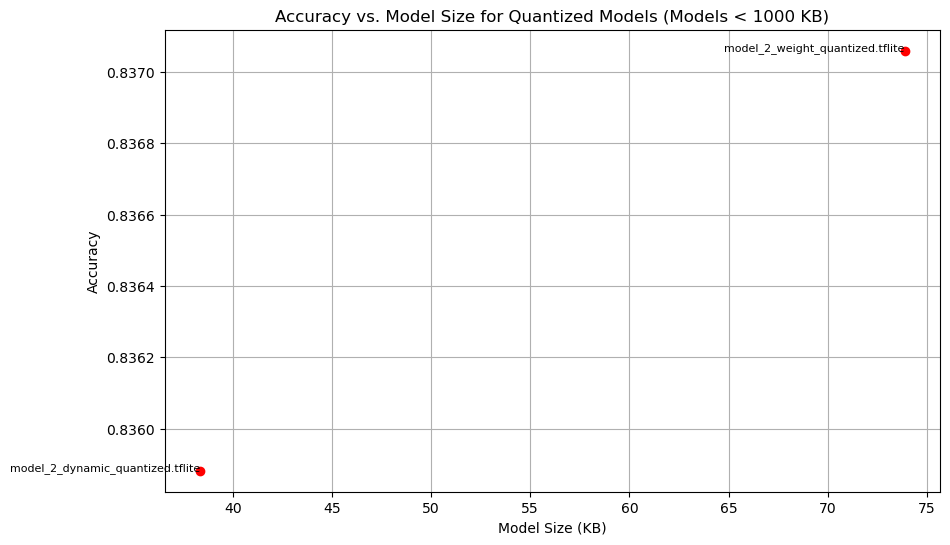

In [32]:
# List of quantized model filenames
quantized_model_filenames = []
for i in range(0, len(models)):
    for strategy in ['weight', 'full', 'dynamic']:
        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')

# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))

# Filter accuracies for models smaller than 1000 KB and accuracy greater than 0.8
filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.8 and tup[1] < 1000]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))

# Plot points without connecting lines by setting linestyle='None'
plt.plot(model_sizes, accuracies, marker='o', linestyle='None', color='r')

# Annotate each point with the model name
for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models (Models < 1000 KB)')
plt.grid(True)
plt.show()


In [33]:
def evaluate_tflite_model(tflite_model_path, test_data, test_labels):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Determine input data type
    input_dtype = input_details[0]['dtype']
    
    # Run inference on the test data
    correct_predictions = 0
    for i, test_sample in enumerate(test_data):
        # Prepare input data, converting to expected dtype if necessary
        input_data = np.expand_dims(test_sample, axis=0)
        if input_dtype == np.uint8:
            input_data = (input_data * 255).astype(np.uint8)  # Scale to UINT8
        else:
            input_data = input_data.astype(input_dtype)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get the output and check the prediction
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = test_labels[i]
        
        if predicted_label == true_label:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / len(test_data)
    return accuracy


def plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds):
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)
    # Lists to store results
    model_sizes = []
    accuracies = []
    model_names = []
    
    # Iterate through all TFLite files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".tflite"):
            model_path = os.path.join(folder_path, filename)
            model_name = os.path.splitext(filename)[0]
            
            # Get model size in KB
            model_size = os.path.getsize(model_path) / 1000  # Convert bytes to KB
            
            # Evaluate the TFLite model accuracy
            accuracy = evaluate_tflite_model(model_path, test_data, test_labels)
            
            # Store results
            model_sizes.append(model_size)
            accuracies.append(accuracy)
            model_names.append(model_name)
            
            # Print the details
            print(f"Model: {model_name}, Size: {model_size:.2f} KB, Accuracy: {accuracy:.4f}")
    
    # Plotting accuracy vs. model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    # Annotate each point with the model name
    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('TFLite Model Accuracy vs. Model Size')
    plt.grid(True)
    plt.show()

    return model_sizes, accuracies, model_names


Model: model_0_dynamic_quantized, Size: 198.22 KB, Accuracy: 0.7735
Model: model_0_full_quantized, Size: 197.22 KB, Accuracy: 0.7659
Model: model_0_int16x8_quantized, Size: 197.23 KB, Accuracy: 0.0600
Model: model_0_weight_quantized, Size: 390.88 KB, Accuracy: 0.7747
Model: model_1_dynamic_quantized, Size: 13.99 KB, Accuracy: 0.7918
Model: model_1_full_quantized, Size: 13.13 KB, Accuracy: 0.7894
Model: model_1_int16x8_quantized, Size: 13.30 KB, Accuracy: 0.0600
Model: model_1_weight_quantized, Size: 21.90 KB, Accuracy: 0.7900
Model: model_2_dynamic_quantized, Size: 39.28 KB, Accuracy: 0.8359
Model: model_2_full_quantized, Size: 40.35 KB, Accuracy: 0.8412
Model: model_2_int16x8_quantized, Size: 40.70 KB, Accuracy: 0.0600
Model: model_2_weight_quantized, Size: 75.66 KB, Accuracy: 0.8371
Model: pruned_qat_tiny_conv_model, Size: 197.30 KB, Accuracy: 0.8076
Model: pruned_qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7924
Model: pruned_qat_tiny_embed_conv_model_best, Size: 40.61 KB,

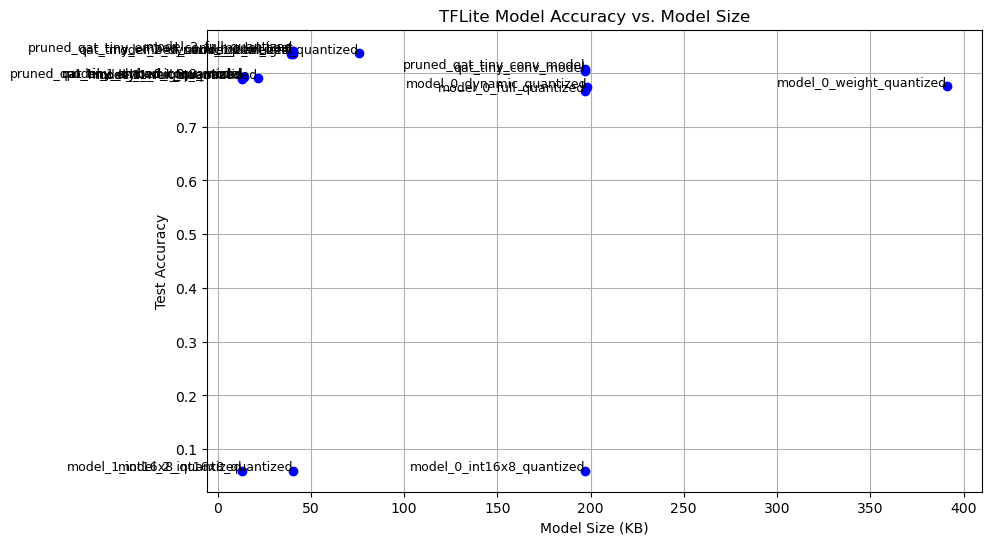

In [34]:
model_sizes, accuracies, model_names = [], [], []
folder_path = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\"
model_sizes, accuracies, model_names = plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds)
# C:\Users\adamk\Downloads\micro_speech_model_making\notebooks\val_spec_ds.tfrecord

In [35]:
for size, acc, name in zip(model_sizes, accuracies, model_names):
    if size < 45 and acc > 0.8:
        print(f"Name : {name}, Size: {size}, Accuracy: {acc}")

Name : model_2_dynamic_quantized, Size: 39.28, Accuracy: 0.8358823529411765
Name : model_2_full_quantized, Size: 40.352, Accuracy: 0.8411764705882353
Name : pruned_qat_tiny_embed_conv_model_best, Size: 40.608, Accuracy: 0.84
Name : qat_tiny_embed_conv_model_best, Size: 40.608, Accuracy: 0.8358823529411765


In [36]:
import matplotlib.pyplot as plt

def plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size, min_accuracy):
    # Filter models based on the provided criteria
    filtered_sizes = [size for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_accuracies = [acc for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_names = [name for size, acc, name in zip(model_sizes, accuracies, model_names) if size < max_size and acc > min_accuracy]

    # Print details of filtered models
    for size, acc, name in zip(filtered_sizes, filtered_accuracies, filtered_names):
        print(f"Name: {name}, Size: {size:.2f} KB, Accuracy: {acc:.4f}")

    # Plot only the filtered models
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_sizes, filtered_accuracies, marker='o', linestyle='', color='b', label=f"Size < {max_size} KB & Accuracy > {min_accuracy*100}%")
    
    # Annotate each filtered point with the model name
    for i, model_name in enumerate(filtered_names):
        plt.text(filtered_sizes[i], filtered_accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title(f'TFLite Model Accuracy vs. Model Size (Filtered by Size < {max_size} KB & Accuracy > {min_accuracy*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()




Name: model_1_dynamic_quantized, Size: 13.99 KB, Accuracy: 0.7918
Name: model_1_full_quantized, Size: 13.13 KB, Accuracy: 0.7894
Name: pruned_qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7924
Name: qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7918


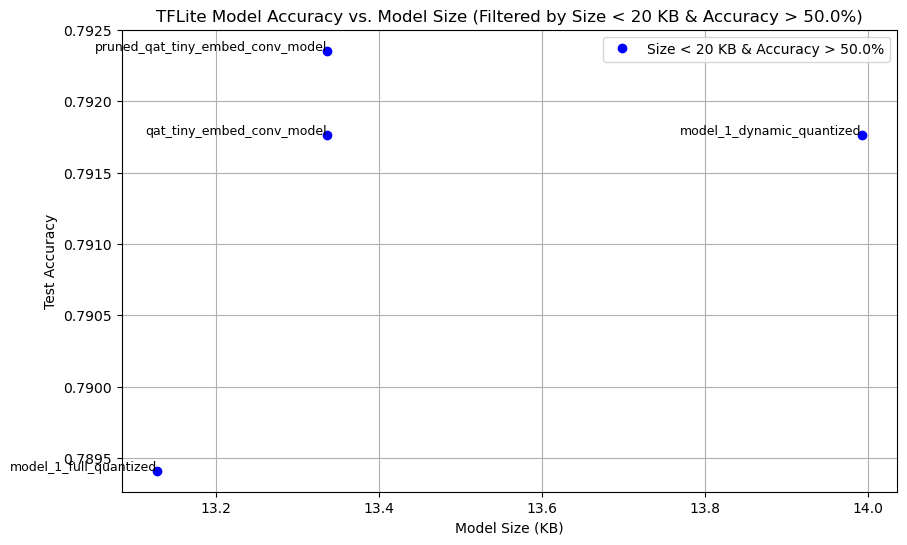

In [37]:
plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size=20, min_accuracy=0.5)